# Notebook for testing how distortions change in Normalizing Flows

In [8]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


In [9]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, create_latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, transform_double
from GAN_utils import GAN_Input, GAN_Input_double

In [10]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"


In [5]:
num_samples = 100
MC_Graphs = GraphDataset(prefix+MCdataset)

#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [6]:
# distorted_inputs = GAN_Input_double(MC_Graphs, distortion_range = (-0.1,0.1), num_features = 20, num_sample_features = 12)
inputs = GAN_Input_double(MC_Graphs, distortion_range = (-0.1,0.1), distort = True, num_features = 20, num_sample_features = 12)

100%|██████████| 1306/1306 [04:22<00:00,  4.97it/s]


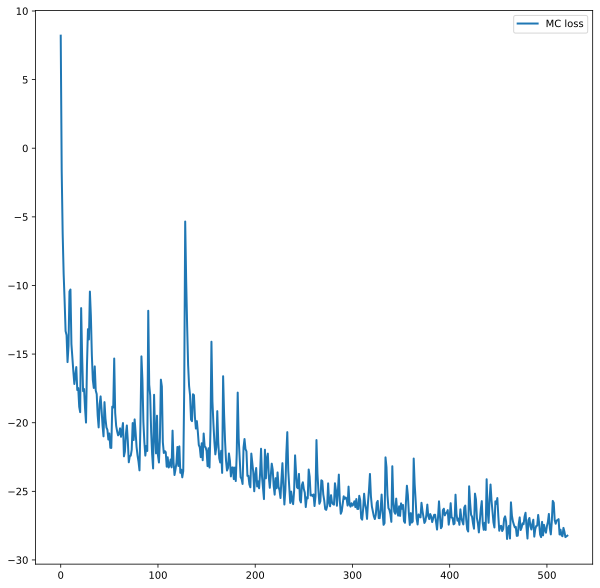

Lowest Loss: -28.471737670898438


In [12]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(latent_dim = 12,hidden_dim = 48,num_layers = 60, alternate_mask = False)
distribution_MC = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

# TRAINING MC
MC_loss, MC_full_loss = train(inputs, MC_model, distorted = False, num_epochs = 4,compact_num = 10)
plot_loss(MC_loss, label = "MC loss",save = True, save_loc = "plots/NF_loss/notebook/July_18_MC_0_1.jpeg")

# MC_model.save("models/NF_distort/MC_july_18_double_features_0_04.pth")

In [ ]:
# masked_affine_flows_train_MC = get_masked_affine(latent_dim = 12,hidden_dim = 36,num_layers = 60)
# distribution_MC = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
# masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
# masked_affine_model_MC.load("models/NF_distort/MC_july_17_double_features.pth")
# MC_model = masked_affine_model_MC.to(device)

In [ ]:
# SETTING UP DATA MODEL

masked_affine_flows_train_distort = get_masked_affine(latent_dim = 12, hidden_dim = 48, num_layers = 60, alternate_mask = False)
distribution_distort = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
masked_affine_model_distort = nf.NormalizingFlow(q0=distribution_distort, flows=masked_affine_flows_train_distort)
distort_model = masked_affine_model_distort.to(device)

# TRAINING Distorted
distort_loss, distort_full_loss = train(inputs, distort_model, distorted = True, num_epochs = 2, compact_num = 10)
plot_loss(distort_loss, label = "Distorted loss",save = True, save_loc = "plots/NF_loss/notebook_distort_0_1.jpeg")

# distort_model.save("models/NF_distort/distort_july_18_double_features_0_04.pth")

In [ ]:
# masked_affine_flows_train_distort = get_masked_affine(latent_dim = 12, hidden_dim = 36, num_layers = 60)
# distribution_distort = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
# masked_affine_model_distort = nf.NormalizingFlow(q0=distribution_distort, flows=masked_affine_flows_train_distort)
# masked_affine_model_distort.load("models/NF_distort/distort_july_16_double_features.pth")
# distort_model = masked_affine_model_distort.to(device)

# Testing MC and DATA models

In [ ]:
# Testing MC
test(inputs, MC_model, data_type = "MC")
# Testing DATA
test(distorted_inputs, distort_model, data_type = "MC distorted", distorted = True)

# Plotting sanity checks

In [ ]:
# normalized_MC = transform(inputs, MC_model)
normalized_distorted = transform_double(inputs, distort_model, distorted = True)

normalized_distorted_obj = Latent_data(normalized_distorted, torch.empty([]))
normalized_distorted_obj.set_batch_size(100)
full_pass_distorted = transform_double(normalized_distorted_obj, MC_model, reverse = False)

In [ ]:
plot_fpd = torch.clone(full_pass_distorted)
plot_distorted_data = torch.clone(inputs.distorted_features)
plot_train_data = torch.clone(inputs.data)
for i in range(len(plot_fpd)):
    for j in range(12):
        if(np.isnan(plot_fpd[i,j])):
            plot_fpd[i,0] = 99999
            plot_train_data[i,0] = 99999
            plot_distorted_data[i,0] = 99999
            break
plot_fpd = plot_fpd[plot_fpd[:,0] != 99999]
plot_distorted_data = plot_distorted_data[plot_distorted_data[:,0] != 99999]
plot_train_data = plot_train_data[plot_train_data[:,0] != 99999]

In [ ]:
len(full_pass_distorted) - len(plot_fpd)

In [ ]:
fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(his1,his2,his3)) = plt.subplots(3,3,figsize = (12,12))
axlist = [ax11,ax12,ax13,ax21,ax22,ax23]
names = ["Proton pT", "Proton phi", "Proton theta", "Pion pT", "Pion phi", "Pion theta"]
fig.suptitle("Distorted vs fullpass with +/-0.04 distortion")
for i in range(6):
    x1 = torch.Tensor.numpy(plot_distorted_data[:,i])
    y1 = torch.Tensor.numpy(plot_fpd[:,i])
    axlist[i].hist2d(x1,y1,bins = 200, cmap = plt.cm.jet)
    axlist[i].set_xlabel(names[i])
ax11.set_xlim(-1,1)
ax11.set_ylim(-1,1)
his1.hist(inputs.data[:,0], bins = 100,color = 'r')
his1.set_xlabel("MC")
his1.set_xlim(-1,1)
his2.hist(inputs.distorted_features[:,0], bins = 100,color = 'b')
his2.set_xlabel("distorted")
his2.set_xlim(-1,1)
his3.hist(full_pass_distorted[:,0], bins = 100,color = 'g')
his3.set_xlabel("fullpass")
his3.set_xlim(-1,1)
fig.show()
fig.savefig("plots/NF_double/distorted_MC_vs_fullpass_july_18_0_04_notebook.jpeg")